In [1]:
! conda info --env

# conda environments:
#
base                     /home/ai-sjjy/anaconda3
juyoung2              *  /home/ai-sjjy/anaconda3/envs/juyoung2
tensorflow2.3            /home/ai-sjjy/anaconda3/envs/tensorflow2.3



## Gensim Word2Vec Tutorial

In [2]:
PATH = "/home/ai-sjjy/workspace/juyoung/AI/NLP/dataset/"

#### [1] Dataset

* Simpsons : https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data
* 데이터 집합은 심슨 부부의 대화 행

In [3]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
df = pd.read_csv(PATH+'simpsons_dataset.csv')
print("dataset shape : ", df.shape)

dataset shape :  (158314, 2)


In [5]:
df.head(3)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...


### [1] 데이터 전처리

#### [1-1] 결측치 확인 및 제거

In [7]:
len(df)

158314

In [6]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

#### [1-2] 데이터 정제

In [11]:
en = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

In [12]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # 하나 또는 두 단어일 경우에는 학습할 부분이 거의 없기 때문에 제거 한다.
    if len(txt) > 2:
        return ' '.join(txt)

In [13]:
# re를 사용해 영어만 남기기 +소문자만 사용하기
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [15]:
# data cleaning
txt = [cleaning(doc) for doc in en.pipe(brief_cleaning, batch_size=5000)]

In [16]:
# 정제된 데이터로 df 새로 생성
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85956, 1)

In [17]:
df_clean.head(3)

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live


### [2] Word2vec

#### [2-1] Bigrams

* "mr_burns" or "bart_simpson"과 같은 단어를 찾기 위해 진행
* 동시등장성을 기반으로 연관있는 단어를 특정한 window size를 기반으로 묶어준다
* 한 문장을 띄어쓰기 단위로 분리를 했을때 효과적으로 단어를 인식하게 도와준다

In [19]:
from gensim.models.phrases import Phrases, Phraser

# 한 문장을 띄어쓰기 단위로 분리
sent = [row.split() for row in df_clean['clean']]

# 모델을 만들어 주기
# min_count : 단어 선택 기준(빈도 횟수)
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 16:34:40: collecting all words and their counts
INFO - 16:34:40: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:34:40: PROGRESS: at sentence #10000, processed 63557 words and 52766 word types
INFO - 16:34:40: PROGRESS: at sentence #20000, processed 130938 words and 99804 word types
INFO - 16:34:40: PROGRESS: at sentence #30000, processed 192959 words and 138457 word types
INFO - 16:34:40: PROGRESS: at sentence #40000, processed 249832 words and 172540 word types
INFO - 16:34:40: PROGRESS: at sentence #50000, processed 311267 words and 208413 word types
INFO - 16:34:40: PROGRESS: at sentence #60000, processed 373573 words and 243501 word types
INFO - 16:34:40: PROGRESS: at sentence #70000, processed 436422 words and 278510 word types
INFO - 16:34:41: PROGRESS: at sentence #80000, processed 497885 words and 311663 word types
INFO - 16:34:41: collected 330422 word types from a corpus of 537096 words (unigram + bigrams) and 85956 sentences
INFO - 16:34:41: us

In [20]:
# # 모델을 만들어 주기 -> bigram
bigram = Phraser(phrases)

INFO - 16:37:31: source_vocab length 330422
INFO - 16:37:33: Phraser built with 126 phrasegrams


In [22]:
# Transform the corpus based on the bigrams detected
sentences = bigram[sent]

In [27]:
print("original sentence : ", sent[1])
print("bigram sentence : ", sentences[1])

original sentence :  ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach']
bigram sentence :  ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach']


In [28]:
# 단어 빈도 확인

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29662

In [29]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

#### [2-2] Word2vec 학습

In [31]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

# Word2Vec 모델 설계
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

# 단어 사전 구축
w2v_model.build_vocab(sentences, progress_per=10000)

INFO - 16:49:12: collecting all words and their counts
INFO - 16:49:12: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:49:12: PROGRESS: at sentence #10000, processed 61704 words, keeping 9490 word types
INFO - 16:49:13: PROGRESS: at sentence #20000, processed 127324 words, keeping 14368 word types
INFO - 16:49:13: PROGRESS: at sentence #30000, processed 187817 words, keeping 17428 word types
INFO - 16:49:13: PROGRESS: at sentence #40000, processed 243317 words, keeping 20115 word types
INFO - 16:49:13: PROGRESS: at sentence #50000, processed 303171 words, keeping 22547 word types
INFO - 16:49:13: PROGRESS: at sentence #60000, processed 363906 words, keeping 24808 word types
INFO - 16:49:13: PROGRESS: at sentence #70000, processed 425365 words, keeping 26972 word types
INFO - 16:49:13: PROGRESS: at sentence #80000, processed 485491 words, keeping 28798 word types
INFO - 16:49:13: collected 29662 word types from a corpus of 523600 raw words and 85956 sentence

In [32]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 16:50:38: training model with 7 workers on 3317 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 16:50:39: EPOCH 1 - PROGRESS: at 86.15% examples, 171396 words/s, in_qsize 0, out_qsize 0
INFO - 16:50:39: worker thread finished; awaiting finish of 6 more threads
INFO - 16:50:39: worker thread finished; awaiting finish of 5 more threads
INFO - 16:50:39: worker thread finished; awaiting finish of 4 more threads
INFO - 16:50:39: worker thread finished; awaiting finish of 3 more threads
INFO - 16:50:39: worker thread finished; awaiting finish of 2 more threads
INFO - 16:50:39: worker thread finished; awaiting finish of 1 more threads
INFO - 16:50:39: worker thread finished; awaiting finish of 0 more threads
INFO - 16:50:39: EPOCH - 1 : training on 523600 raw words (199750 effective words) took 1.1s, 175482 effective words/s
INFO - 16:50:40: EPOCH 2 - PROGRESS: at 88.14% examples, 168820 words/s, in_qsize 0, out_qsize 1
INFO - 16:50:40: worker thre

(5985157, 15708000)

In [33]:
# memory 효율적으로 쓰기 위해서 init_sim 함수 사용
w2v_model.init_sims(replace=True)

INFO - 16:52:51: precomputing L2-norms of word weight vectors


### [3] Exploring the model

* most_similar()

In [34]:
# homer와 가장 유사한 단어 추출
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7878647446632385),
 ('sweetheart', 0.7603409290313721),
 ('snuggle', 0.7542224526405334),
 ('rude', 0.7468377351760864),
 ('depressed', 0.741464376449585),
 ('ralphie', 0.735263466835022),
 ('gee', 0.7327444553375244),
 ('maybe', 0.7236717939376831),
 ('crummy', 0.7215182781219482),
 ('worry', 0.7115130424499512)]

In [35]:
# 심슨 아내 marge와 유사한 단어 추출
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.7878648638725281),
 ('rude', 0.7778794765472412),
 ('snuggle', 0.7762696146965027),
 ('attract', 0.7683857083320618),
 ('married', 0.7631385326385498),
 ('decent', 0.7496177554130554),
 ('talk', 0.7484679818153381),
 ('promise', 0.7468622922897339),
 ('depressed', 0.7455981969833374),
 ('vegas', 0.7453100681304932)]

In [36]:
# 심슨 아들 bart와 유사한 단어
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8846532106399536),
 ('grownup', 0.8081477880477905),
 ('upset', 0.8071808815002441),
 ('milhouse', 0.7975910305976868),
 ('creepy', 0.7965853214263916),
 ('hearing', 0.7880057096481323),
 ('bedtime', 0.7871900796890259),
 ('badly', 0.7817173004150391),
 ('mom', 0.7812662124633789),
 ('substitute', 0.7788379192352295)]

In [44]:
# 좀 더 복합적으로 유사 단어 추출
# positive는 이 단어와 유사한 단어 후보군 추출
# 뽑은 postivie 후보군 중에서 negative에 해당되는 단어 제거
# 그중 top 3 단어 추출
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.7158202528953552),
 ('juliet', 0.6922623515129089),
 ('man', 0.6834419965744019)]

In [45]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.807114839553833),
 ('surprised', 0.727683424949646),
 ('assignment', 0.727362871170044)]

* similarity()

In [38]:
# 두 단어의 유사도
w2v_model.wv.similarity("moe", 'tavern')

0.8763779

In [39]:
# maggie는 심슨에서 유명한 아기이다
w2v_model.wv.similarity('maggie', 'baby')

0.7409804

In [40]:
# bart와 nelson은 친구 사이이다
w2v_model.wv.similarity('bart', 'nelson')

0.7186389

In [41]:
# bart는 애기가 아니다
w2v_model.wv.similarity('bart', 'baby')

0.4914704

* doesnt_match()

In [42]:
# Jimbo, Milhouse, Kearney 중 유사도 떨어지는 단어는
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 17:05:41: vectors for words {'kearney'} are not present in the model, ignoring these words
/home/ai-sjjy/anaconda3/envs/juyoung2/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jimbo'

In [43]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

### [4] t-SNE 시각화

* t-SNE은 비선형 차원 축소 알고리즘이다
* 300차원 벡터를 2차원 그래프로 표시하고 흥미로운 패턴을 찾아내기

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [61]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f') # 벡터 초기화 => 쿼리, 유사, 유사도 떨어지는 단어 모음
    word_labels = [word] # target 단어
    color_list  = ['red'] # target 단어 색(빨간)

    # adds the vector of the query word
    # 해당 단어(target)의 임베딩 벡터 가져옴
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0) 
    
    # 유사한 단어 리스트 가져오기
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    # ('lisa', 0.8846532106399536)
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]]) # 해당 단어(target)의 임베딩 벡터 가져옴
        word_labels.append(wrd_score[0]) 
        color_list.append('blue') # 유사 단어는 'blue' 색 지정
        arrays = np.append(arrays, wrd_vector, axis=0) # 행 추가
    
    # adds the vector for each of the words from list_names to the array
    # 쿼리로 받은 단어들 추출
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    print(arrays.shape)
    # 차원 축소 300 => 50
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

(19, 300)


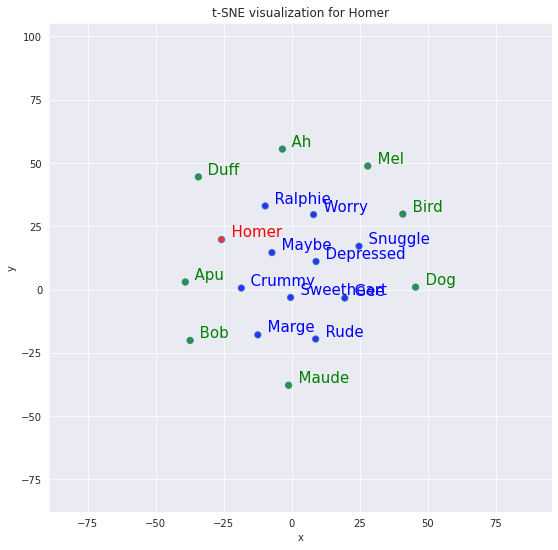

In [62]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

(21, 300)


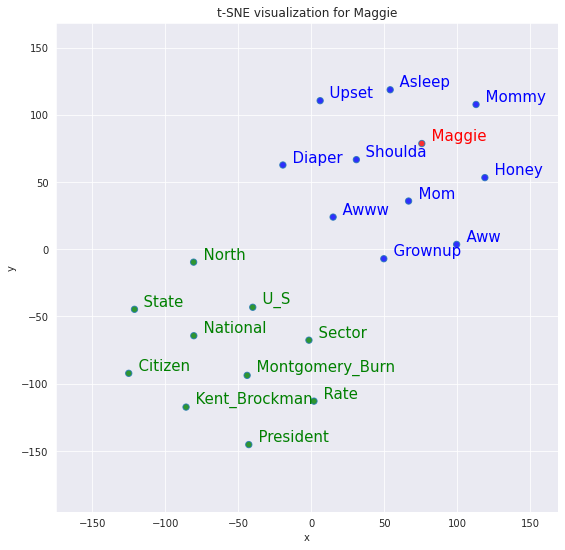

In [63]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

(21, 300)


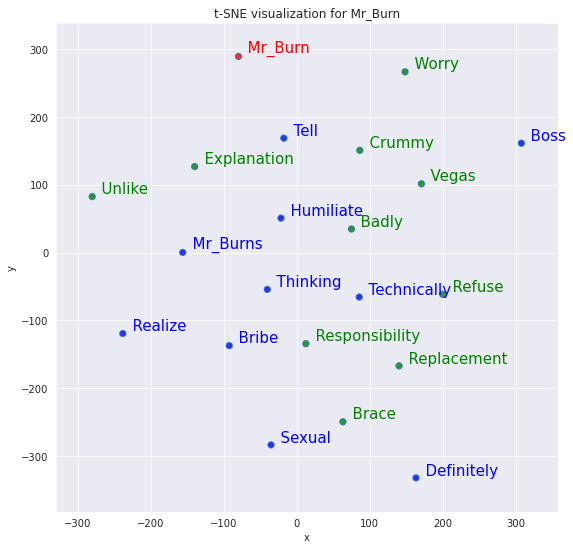

In [64]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])